In [ ]:
!pip install SimpleITK
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 25.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import pandas as pd
import torch
import seaborn as sns
import pickle
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import SimpleITK as sitk
import tensorflow as tf
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
import pandas as pd
from sklearn.manifold import TSNE
from skimage.feature import hog
from skimage.transform import resize
from PIL import Image
import configparser
from sklearn.multioutput import MultiOutputClassifier
from google.colab import drive
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,classification_report,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,balanced_accuracy_score,roc_auc_score
from imblearn.over_sampling import RandomOverSampler
import cv2
from time import perf_counter
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = torch.LongTensor(labels)
        self.transform = transform

    def __getitem__(self, index):
        x = self.images[index]
        y = self.labels[index]

        if self.transform:
            x = Image.fromarray(self.images[index].astype(np.uint8).transpose(1, 2, 0))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.images)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def evaluate(model, val_loader):
    outputs = [model.validation_step(to_device(batch,device)) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def model_checkpoint(filename,model):
    torch.save(model.state_dict(), filename)

def save_checkpoint(epoch,model,optimizer):
    checkpoint = {
    'epoch': epoch + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
    }
    return 0

def load_checkpoint(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

def fit(epochs, lr, model, train_loader, val_loader,filename,patient_epochs,restore_best_weights=True,opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    es=EarlyStopping()
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        model_checkpoint(filename,model)
        stop=early_stopping(model,history,patient_epochs,es,restore_best_weights,filename)
        if stop == True :
           print(f"Early stopping at epoch {epoch}")
           continue
    return history


def early_stopping(model,history,patient_epochs,es,restore_best_weights,filename):
    val_losses = [x['val_loss'] for x in history]
    size = len(val_losses)
    last_loss=val_losses[size-1]
    threshold=0
    if es.get_best_loss() >= last_loss:
             es.set_best_loss(last_loss)
             es.set_best_model(model)
    if size > 1 :
          last_but_one_loss=val_losses[size-2]
          if last_loss-last_but_one_loss > threshold :
             es.increase_counter()
          else :
             es.null_counter()
    if es.get_counter() >= patient_epochs:
       if restore_best_weights == True :
              model_checkpoint(es.get_best_model(),filename)
       return True
    print(f"Early stopping counter is {es.get_counter()}")
    return False

class EarlyStopping():
    def __init__(self):
      self.counter=0
      self.best_loss=1
      self.best_model=float("nan")

    def increase_counter(self):
      self.counter+=1

    def get_counter(self):
      return self.counter

    def null_counter(self):
      self.counter=0

    def get_best_loss(self):
      return self.best_loss

    def set_best_loss(self,best_loss):
       self.best_loss=best_loss

    def set_best_model(self,best_model):
       self.best_model=best_model

    def get_best_model(self):
       return self.best_model

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def predict_image(img, model):
    dataset=[]
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return preds[0].item()

def predict_image_softmax(img,model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    yb_softmax=torch.softmax(yb,dim=1)
    tensor, preds  = torch.max(yb_softmax, dim=1)
    return tensor[0].item()

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = to_device(batch,device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = to_device(batch,device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


class ClassificationModel(ImageClassificationBase):
    def __init__(self,num_classes=2):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))

        x = self.relu(self.batch_norm2(self.conv2(x)))

        x = self.conv3(x)
        x = self.batch_norm3(x)

        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)

        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()


        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x

class ResNet(ImageClassificationBase):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion

        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)

In [ ]:
import re
from collections import OrderedDict
from functools import partial
from typing import Any, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch import Tensor


class _DenseLayer(nn.Module):
    def __init__(
        self, num_input_features: int, growth_rate: int, bn_size: int, drop_rate: float, memory_efficient: bool = False
    ) -> None:
        super().__init__()
        self.norm1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)

        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs: List[Tensor]) -> Tensor:
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input: List[Tensor]) -> bool:
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input: List[Tensor]) -> Tensor:
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: List[Tensor]) -> Tensor:  # noqa: F811
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: Tensor) -> Tensor:  # noqa: F811
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input: Tensor) -> Tensor:  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(
        self,
        num_layers: int,
        num_input_features: int,
        bn_size: int,
        growth_rate: int,
        drop_rate: float,
        memory_efficient: bool = False,
    ) -> None:
        super().__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module("denselayer%d" % (i + 1), layer)

    def forward(self, init_features: Tensor) -> Tensor:
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features: int, num_output_features: int) -> None:
        super().__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)


class DenseNet121(ImageClassificationBase):
    def __init__(
        self,
        growth_rate: int = 32,
        block_config: Tuple[int, int, int, int] = (6, 12, 24, 16),
        num_init_features: int = 64,
        bn_size: int = 4,
        drop_rate: float = 0,
        num_classes: int = 2,
        memory_efficient: bool = False,
    ) -> None:

        super().__init__()
        # First convolution
        self.features = nn.Sequential(
            OrderedDict(
                [
                    ("conv0", nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
                    ("norm0", nn.BatchNorm2d(num_init_features)),
                    ("relu0", nn.ReLU(inplace=True)),
                    ("pool0", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                ]
            )
        )

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.features.add_module("denseblock%d" % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module("transition%d" % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module("norm5", nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out



def _densenet(
    growth_rate: int,
    block_config: Tuple[int, int, int, int],
    num_init_features: int,
    progress: bool,
    **kwargs: Any,
) -> DenseNet121:
    return  model

In [ ]:
class Convolutional_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        ### encoder
        self.conv1 = nn.Conv2d(3,64,5)
        self.maxpool = nn.MaxPool2d(2,return_indices=True)
        self.conv2 = nn.Conv2d(64,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        ### decoder
        self.deconv1 = nn.ConvTranspose2d(128,64,5)
        self.unpool = nn.MaxUnpool2d(2)
        self.deconv2 = nn.ConvTranspose2d(64,64,5)
        self.deconv3 = nn.ConvTranspose2d(64,3,5)

    def forward(self,x):
        x = self.conv1(x)
        x,ind1 = self.maxpool(x)
        x = self.conv2(x)
        x,ind2 = self.maxpool(x)
        x = self.conv3(x)
        x = self.deconv1(x)
        x = self.unpool(x,ind2)
        x = self.deconv2(x)
        x = self.unpool(x,ind1)
        x = self.deconv3(x)
        return x

In [ ]:
device=get_default_device()
nb_frames_4ch_list=[]
nb_frames_2ch_list=[]
ages_list=[]
sex_list=[]
image_quality_4ch_list=[]
image_quality_2ch_list=[]

In [ ]:
for i in range(1,451):
    if i<10:
         file_name_4ch= 'drive/MyDrive/training_dataset/training/patient000'+str(i)+'/Info_4CH.cfg'
         file_name_2ch= 'drive/MyDrive/training_dataset/training/patient000' +str(i) +'/Info_2CH.cfg'
    elif i<100 :
         file_name_4ch= 'drive/MyDrive/training_dataset/training/patient00'+str(i)+'/Info_4CH.cfg'
         file_name_2ch= 'drive/MyDrive/training_dataset/training/patient00' +str(i) +'/Info_2CH.cfg'
    else :
         file_name_4ch= 'drive/MyDrive/training_dataset/training/patient0'+str(i)+'/Info_4CH.cfg'
         file_name_2ch= 'drive/MyDrive/training_dataset/training/patient0' +str(i) +'/Info_2CH.cfg'
    with open(file_name_4ch) as f:
        file_content = '[dummy_section]\n' + f.read()
    config_parser =configparser.RawConfigParser()
    config_parser.read_string(file_content)
    ages_list.append(int(config_parser['dummy_section']['Age']))
    sex_list.append(config_parser['dummy_section']['Sex'])
    nb_frames_4ch_list.append(int(config_parser['dummy_section']['NbFrame']))
    image_quality_4ch_list.append(config_parser['dummy_section']['ImageQuality'])
    with open(file_name_2ch) as f:
        file_content = '[dummy_section]\n' + f.read()
    config_parser =configparser.RawConfigParser()
    config_parser.read_string(file_content)
    nb_frames_2ch_list.append(int(config_parser['dummy_section']['NbFrame']))
    image_quality_2ch_list.append(config_parser['dummy_section']['ImageQuality'])

In [ ]:
dataframe=pd.DataFrame({'Age':ages_list,'Sex':sex_list,'Image_quality_4ch':image_quality_4ch_list,'Nb_frames_4ch':nb_frames_4ch_list,'Image_quality_2ch':image_quality_2ch_list,'Nb_frames_2ch':nb_frames_2ch_list})
dataframe['patient']=range(1,451)
print(dataframe)
print("Total 4ch examples")
size=len(dataframe)
print(dataframe['Nb_frames_4ch'].sum())
print("Total 2ch examples")
print(dataframe['Nb_frames_2ch'].sum())

     Age Sex Image_quality_4ch  Nb_frames_4ch Image_quality_2ch  \
0     56   F              Good             20              Good   
1     55   M            Medium             15            Medium   
2     36   F              Good             21              Good   
3     79   F            Medium             18              Good   
4     78   F              Good             20            Medium   
..   ...  ..               ...            ...               ...   
445   55   M            Medium             19              Poor   
446   57   M              Poor             13            Medium   
447   57   F              Good             18              Poor   
448   84   M            Medium             16              Poor   
449   72   M              Good             18              Good   

     Nb_frames_2ch  patient  
0               18        1  
1               17        2  
2               17        3  
3               19        4  
4               20        5  
..             

In [ ]:
print(dataframe['Image_quality_4ch'].value_counts())
print(dataframe['Image_quality_2ch'].value_counts())

Good      260
Medium    148
Poor       42
Name: Image_quality_4ch, dtype: int64
Good      198
Medium    193
Poor       59
Name: Image_quality_2ch, dtype: int64


In [ ]:
print(dataframe['Sex'].value_counts())
print(dataframe["Nb_frames_4ch"].loc[dataframe["Image_quality_4ch"] == "Poor" ].sum())
print(dataframe["Nb_frames_4ch"].loc[dataframe["Image_quality_4ch"] == "Medium" ].sum())
print(dataframe["Nb_frames_4ch"].loc[dataframe["Image_quality_4ch"] == "Good" ].sum())
print(dataframe["Nb_frames_2ch"].loc[dataframe["Image_quality_2ch"] == "Poor" ].sum())
print(dataframe["Nb_frames_2ch"].loc[dataframe["Image_quality_2ch"] == "Medium" ].sum())
print(dataframe["Nb_frames_2ch"].loc[dataframe["Image_quality_2ch"] == "Good" ].sum())

M    292
F    158
Name: Sex, dtype: int64
850
2858
5268
1106
3508
3674


In [ ]:
colors=['red','black']
#sns.countplot(dataframe['Sex'],palette=colors)
fig,ax1= plt.subplots(ncols=1, figsize=(10, 5))
dataframe.groupby('Sex').size().plot(kind='pie', autopct='%.2f')
ax1.set_ylabel('Sex', size=22)

In [ ]:
Y=np.zeros(len(dataframe))
X_train_dataframe,Val_set_dataframe,Y_train,Y_test=train_test_split(dataframe, Y, test_size=0.2,stratify=dataframe['Image_quality_4ch'],random_state=42)
print(X_train_dataframe.shape)
print(Val_set_dataframe.shape)

(360, 7)
(90, 7)


In [ ]:
print(X_train_dataframe)
print(Val_set_dataframe)

     Age Sex Image_quality_4ch  Nb_frames_4ch Image_quality_2ch  \
378   51   F              Good             18              Good   
82    87   F            Medium             21              Good   
141   59   M              Good             22              Good   
42    86   M            Medium             14            Medium   
321   77   M              Good             30              Good   
..   ...  ..               ...            ...               ...   
363   73   M            Medium             13            Medium   
412   68   F              Good             20              Good   
418   85   F              Good             29            Medium   
52    65   M              Good             16              Good   
221   58   M              Good             19              Good   

     Nb_frames_2ch  patient  
378             16      379  
82              14       83  
141             16      142  
42              21       43  
321             30      322  
..             

In [ ]:
dataframe=X_train_dataframe
print(dataframe['Image_quality_4ch'].value_counts())
print(dataframe['Image_quality_2ch'].value_counts())

Good      208
Medium    118
Poor       34
Name: Image_quality_4ch, dtype: int64
Good      162
Medium    150
Poor       48
Name: Image_quality_2ch, dtype: int64


In [ ]:
print(dataframe['Sex'].value_counts())
print(dataframe["Nb_frames_4ch"].loc[dataframe["Image_quality_4ch"] == "Poor" ].sum())
print(dataframe["Nb_frames_4ch"].loc[dataframe["Image_quality_4ch"] == "Medium" ].sum())
print(dataframe["Nb_frames_4ch"].loc[dataframe["Image_quality_4ch"] == "Good" ].sum())
print(dataframe["Nb_frames_2ch"].loc[dataframe["Image_quality_2ch"] == "Poor" ].sum())
print(dataframe["Nb_frames_2ch"].loc[dataframe["Image_quality_2ch"] == "Medium" ].sum())
print(dataframe["Nb_frames_2ch"].loc[dataframe["Image_quality_2ch"] == "Good" ].sum())

M    234
F    126
Name: Sex, dtype: int64
701
2294
4221
904
2751
2987


In [ ]:
preprocessing = torchvision.transforms.Compose([
   torchvision.transforms.ToPILImage(),
   torchvision.transforms.Resize((224,224)),
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize(mean=[0], std=[1])
])

In [ ]:
print(dataframe)

(15, 1167, 748)


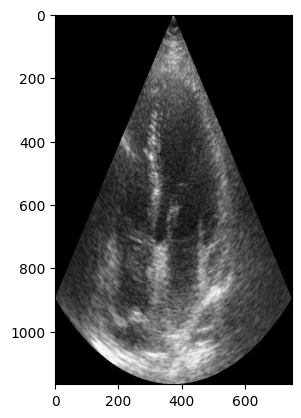

In [ ]:
image_file_path="drive/MyDrive/training_dataset/training/patient0002/patient0002_4CH_sequence.mhd"
img = sitk.ReadImage(image_file_path)
img_4=sitk.GetArrayFromImage(img)
plt.imshow(img_4[0,:,:], cmap='gray')
print(img_4.shape)
#rgb_image = cv2.cvtColor(img_4[0,:,:],cv2.COLOR_GRAY2RGB)
#print(rgb_image.shape)
#plt.imshow(rgb_image)

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
image_file_path="drive/MyDrive/training_dataset/training/patient0001/patient0001_2CH_sequence.mhd"
img = sitk.ReadImage(image_file_path)
img_4=sitk.GetArrayFromImage(img)
fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1,3),
                 axes_pad=0.1,
                 )
for ax, im in zip(grid,img_4):
    ax.imshow(im,cmap="gray")


In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
img_4=[]
image_file_path="drive/MyDrive/training_dataset/training/patient0001/patient0001_2CH_sequence.mhd"
img = sitk.ReadImage(image_file_path)
img_1=sitk.GetArrayFromImage(img)
img_4.append(img_1)
image_file_path="drive/MyDrive/training_dataset/training/patient0001/patient0001_2CH_sequence.mhd"
img = sitk.ReadImage(image_file_path)
img_1=sitk.GetArrayFromImage(img)
img_4.append(img_1)
image_file_path="drive/MyDrive/training_dataset/training/patient0001/patient0001_2CH_sequence.mhd"
img = sitk.ReadImage(image_file_path)
img_1=sitk.GetArrayFromImage(img)
img_4.append(img_1)

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1,3),
                 axes_pad=0.1,
                 )
for ax, im in zip(grid,img_4):
    ax.imshow(im,cmap="gray")
    ax.axis('off')

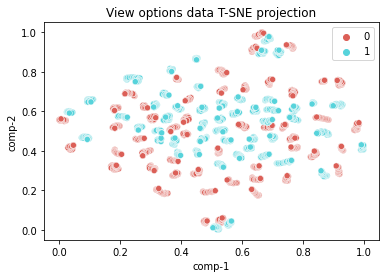

In [ ]:
def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

def tsne_plot(X,Y):
    tsne = TSNE(n_components=2,learning_rate='auto',init='random', perplexity=30,n_iter=1000).fit_transform(X)
    tx = tsne[:, 0]
    ty = tsne[:, 1]
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)
    df = pd.DataFrame()
    df["y"] = Y
    df["comp-1"] = tx
    df["comp-2"] = ty
    sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="View options data T-SNE projection")


X,Y=create_hog_dataset_test(patients=51)
tsne_plot(X,Y)

In [ ]:
print(features.shape)

(48, 1024)


In [ ]:
def fetch_file(patient,option):
      if patient >= 100 :
          image_path_4ch = "drive/MyDrive/training_dataset/training/patient0"+str(patient)+"/patient0"+str(patient)+"_4CH_sequence.mhd"
          image_path_2ch = "drive/MyDrive/training_dataset/training/patient0"+str(patient)+"/patient0"+str(patient)+"_2CH_sequence.mhd"
      elif patient >= 10 :
          image_path_4ch = "drive/MyDrive/training_dataset/training/patient00"+str(patient)+"/patient00"+str(patient)+"_4CH_sequence.mhd"
          image_path_2ch = "drive/MyDrive/training_dataset/training/patient00"+str(patient)+"/patient00"+str(patient)+"_2CH_sequence.mhd"
      else:
          image_path_4ch = "drive/MyDrive/training_dataset/training/patient000"+str(patient)+"/patient000"+str(patient)+"_4CH_sequence.mhd"
          image_path_2ch = "drive/MyDrive/training_dataset/training/patient000"+str(patient)+"/patient000"+str(patient)+"_2CH_sequence.mhd"
      if option=='4CH' :
         image_path=image_path_4ch
      else :
         image_path=image_path_2ch
      return image_path



In [ ]:
def get_array(image_path) :
   img = sitk.ReadImage(image_path)
   array = sitk.GetArrayFromImage(img)
   return array

In [ ]:
def get_image_quality_label(image_quality):
  if image_quality == 'Good' :
     label=0
  elif image_quality == 'Medium' :
     label=1
  else :
     label=2
  return label

In [ ]:
def create_tensor_set(data_set):
    dataset=list()
    dataset_labels=list()
    for i in range(len(data_set)):
      patient=data_set['patient'].iloc[i]
      image_4ch_file=fetch_file(patient=patient,option='4CH')
      image_2ch_file=fetch_file(patient=patient,option='2CH')
      image_4ch=get_array(image_4ch_file)
      image_2ch=get_array(image_2ch_file)
      for j in range(image_4ch.shape[0]):
             rgb_image = cv2.cvtColor(image_4ch[j,:,:],cv2.COLOR_GRAY2RGB)
             tensor_image=preprocessing(rgb_image)
             dataset.append(tensor_image)
             dataset_labels.append(0)
      for j in range(image_2ch.shape[0]):
             rgb_image = cv2.cvtColor(image_2ch[j,:,:],cv2.COLOR_GRAY2RGB)
             tensor_image=preprocessing(rgb_image)
             dataset.append(tensor_image)
             dataset_labels.append(1)
    return dataset,dataset_labels

In [ ]:
def create_tensor_set_test_quality():
    dataset=list()
    dataset_labels=list()
    for patient in range(1,51):
      image_4ch_file=fetch_test_file(patient=patient,option='4CH')
      #image_2ch_file=fetch_test_file(patient=patient,option='2CH')
      image_4ch=get_array(image_4ch_file)
      #image_2ch=get_array(image_2ch_file)
      quality_label_4ch=fetch_test_image_quality(patient=patient,option="4CH")
      #quality_label_2ch=fetch_test_image_quality(patient=patient,option="2CH")
      label_4ch=get_image_quality_label(quality_label_4ch)
      #label_2ch=get_image_quality_label(quality_label_2ch)
      for j in range(image_4ch.shape[0]):
             rgb_image = cv2.cvtColor(image_4ch[j,:,:],cv2.COLOR_GRAY2RGB)
             tensor_image=preprocessing(rgb_image)
             dataset.append(tensor_image)
             dataset_labels.append(label_4ch)
      #for j in range(image_2ch.shape[0]):
             #rgb_image = cv2.cvtColor(image_2ch[j,:,:],cv2.COLOR_GRAY2RGB)
             #tensor_image=preprocessing(rgb_image)
             #dataset.append(tensor_image)
             #dataset_labels.append(label_2ch)
    return dataset,dataset_labels

In [ ]:
def torch_sampler(images,labels):
   dataset=list()
   index_list=range(len(images))
   index_list,labels=sampling_strategy(np.array(index_list).reshape(-1,1),labels)
   index_list=np.ravel(index_list).tolist()
   for index in index_list:
     dataset.append(images[index])
   print(len(dataset))
   return dataset,labels

In [ ]:
device=get_default_device()
images,labels=create_tensor_set_quality(X_train_dataframe)
print(len(images))
#images,labels=torch_sampler(images,labels)
train_ds=MyDataset(images=images,labels=labels)
images,labels=create_tensor_set_quality(Val_set_dataframe)
val_ds=MyDataset(images=images,labels=labels)
#images,labels=create_tensor_set_quality(X_test_dataframe)
#test_ds=MyDataset(images=images,labels=labels)
batch_size=16
train_loader = DataLoader(train_ds, batch_size,shuffle=True,num_workers=4, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=False)
#test_loader = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=False)
#train_dl = DeviceDataLoader(train_loader, device)
#val_dl = DeviceDataLoader(val_loader, device)
#test_dl = DeviceDataLoader(test_loader, device)

In [ ]:
device=get_default_device()
images,labels=create_tensor_set(X_train_dataframe)
train_ds=MyDataset(images=images,labels=labels)
images,labels=create_tensor_set(Val_set_dataframe)
val_ds=MyDataset(images=images,labels=labels)
#images,labels=create_tensor_set(X_test_dataframe)
#test_ds=MyDataset(images=images,labels=labels)
batch_size=32
train_loader = DataLoader(train_ds, batch_size,shuffle=True,num_workers=4, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=False)
#test_loader = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=False)
#train_dl = DeviceDataLoader(train_loader, device)
#val_dl = DeviceDataLoader(val_loader, device)
#test_dl = DeviceDataLoader(test_loader, device)

In [ ]:
images,labels=create_tensor_set(Val_set_dataframe)
val_ds=MyDataset(images=images,labels=labels)
batch_size=16
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=False)

In [ ]:
filename='drive/MyDrive/training_dataset/resnet152_450_0.001_best.pt'
model=load_model_resnet152(filename)
evaluate(model,val_loader)

{'val_loss': 0.07404372096061707, 'val_acc': 0.9783878326416016}

In [ ]:
def video_level_classification(patient,model):
  image_4ch_file=fetch_test_file(patient=patient,option='4CH')
  image_2ch_file=fetch_test_file(patient=patient,option='2CH')
  image_4ch=get_array(image_4ch_file)
  image_2ch=get_array(image_2ch_file)
  correct_4ch=0
  correct_2ch=0
  for j in range(image_4ch.shape[0]):
             rgb_image = cv2.cvtColor(image_4ch[j,:,:],cv2.COLOR_GRAY2RGB)
             tensor_image = preprocessing(rgb_image)
             prediction = predict_image(tensor_image,model)
             if prediction == 1 :
               correct_4ch = correct_4ch + 1
  for j in range(image_2ch.shape[0]):
             rgb_image = cv2.cvtColor(image_2ch[j,:,:],cv2.COLOR_GRAY2RGB)
             tensor_image=preprocessing(rgb_image)
             prediction = predict_image(tensor_image,model)
             if prediction == 1 :
               correct_2ch = correct_2ch + 1
  return correct_4ch/image_4ch.shape[0],correct_2ch/image_2ch.shape[0]

In [ ]:
filename='drive/MyDrive/training_dataset/densenet121_450_0.001_best.pt'
model=load_model_densenet(filename)
patients_4ch=list()
patients_2ch=list()
for patient in range(1,51):
    video_4ch,video_2ch=video_level_classification(patient=patient,model=model)
    patients_4ch.append(video_4ch)
    patients_2ch.append(video_2ch)

In [ ]:
print(patients_4ch)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
patient_4ch = pd.Series(patients_4ch)

patient_4ch.plot.hist(grid=True, bins=30, rwidth=0.9,
                   color='#607c8e')
plt.title('Video Success precentages for 4ch Chamber view')
plt.xlabel('Percentage of Correct Classification')
plt.ylabel('Number of Patients')
plt.grid(axis='y', alpha=0.75)

In [ ]:
patient_2ch = pd.Series(patients_2ch)

patient_2ch.plot.hist(grid=True, bins=30, rwidth=0.9,
                   color='#607c8e')
plt.title('Video Success precentages for 2ch Chamber view')
plt.xlabel('Percentage of Correct Classification')
plt.ylabel('Number of Patients')
plt.grid(axis='y', alpha=0.75)

In [ ]:
def get_view_label(view_option):
  if view_option == '4CH':
    return 0
  return 1

In [ ]:
def create_quality_testing(quality_option,view_option):
  images=list()
  labels=list()
  label=get_view_label(view_option)
  for patient in range(1,51):
    image_quality=fetch_test_image_quality(patient=patient,option=view_option)
    if image_quality != quality_option:
       continue
    image_file=fetch_test_file(patient=patient,option=view_option)
    image=get_array(image_file)
    for j in range(image.shape[0]):
        rgb_image = cv2.cvtColor(image[j,:,:],cv2.COLOR_GRAY2RGB)
        tensor_image=preprocessing(rgb_image)
        images.append(tensor_image)
        labels.append(label)
  print(len(images))
  return images,labels

In [ ]:
device=get_default_device()
images,labels=create_tensor_set_test_quality()
quality_ds=MyDataset(images=images,labels=labels)
batch_size=16
quality_loader = DataLoader(quality_ds, batch_size*2, num_workers=2, pin_memory=False)

In [ ]:
filename='drive/MyDrive/training_dataset/resnet152_quality_0.001.pt'
model=load_model_resnet152(filename)
print_perfomance_metrics(model,quality_loader)

              precision    recall  f1-score   support

        Good       0.78      0.81      0.80       573
      Medium       0.49      0.41      0.45       324
        Poor       0.27      0.35      0.31        91

    accuracy                           0.64       988
   macro avg       0.51      0.53      0.52       988
weighted avg       0.64      0.64      0.64       988

[[466  90  17]
 [123 133  68]
 [  9  50  32]]
0.5251352347047519


In [ ]:
filename='drive/MyDrive/training_dataset/densenet121_450_0.001_best.pt'
model=load_model_densenet(filename)
print_perfomance_metrics(model,poor_4ch_loader)

In [ ]:
filename='drive/MyDrive/training_dataset/densenet121_450_0.001_best.pt'
model=load_model_densenet(filename)
device=get_default_device()
images,labels=create_tensor_test_set()
test_ds=MyDataset(images=images,labels=labels)
batch_size=32
test_loader = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=False)
print_perfomance_metrics(model,test_loader)

[[983   5]
 [ 12 968]]
0.9913617886178862


In [ ]:
print_perfomance_metrics(model,test_loader)

In [ ]:
evaluate(model,good_2ch_loader)

{'val_loss': 1.7652406692504883, 'val_acc': 0.7006122469902039}

In [ ]:
def create_tensor_test_set():
    dataset=list()
    dataset_labels=list()
    for patient in range(1,51):
      image_4ch_file=fetch_test_file(patient=patient,option='4CH')
      image_2ch_file=fetch_test_file(patient=patient,option='2CH')
      image_4ch=get_array(image_4ch_file)
      image_2ch=get_array(image_2ch_file)
      for j in range(image_4ch.shape[0]):
             rgb_image = cv2.cvtColor(image_4ch[j,:,:],cv2.COLOR_GRAY2RGB)
             tensor_image=preprocessing(rgb_image)
             dataset.append(tensor_image)
             dataset_labels.append(0)
      for j in range(image_2ch.shape[0]):
             rgb_image = cv2.cvtColor(image_2ch[j,:,:],cv2.COLOR_GRAY2RGB)
             tensor_image=preprocessing(rgb_image)
             dataset.append(tensor_image)
             dataset_labels.append(1)
    return dataset,dataset_labels

In [ ]:
device=get_default_device()
images,labels=create_tensor_test_set()
test_ds=MyDataset(images=images,labels=labels)
batch_size=16
test_loader = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=False)

In [ ]:
def print_perfomance_metrics(model,test_loader):
   Y_true=np.array([])
   Y_pred=np.array([])
   for batch in test_loader:
      images, labels = to_device(batch,device)
      outputs=model(images)
      _, pred_labels = torch.max(outputs, dim=1)
      Y_true=np.append(Y_true,labels.cpu().numpy())
      Y_pred=np.append(Y_pred,pred_labels.cpu().numpy())
   labels=['Good','Medium','Poor']
   print(classification_report(Y_true, Y_pred, target_names=labels))
   print(confusion_matrix(Y_true, Y_pred))
   #print(accuracy_score(Y_true,Y_pred))
   print(balanced_accuracy_score(Y_true,Y_pred))

In [ ]:
filename='drive/MyDrive/training_dataset/resnet152_450_0.001_best.pt'
model=load_model_resnet152(filename)
print_perfomance_metrics(model,test_loader)

              precision    recall  f1-score   support

         4CH       1.00      0.96      0.98       988
         2CH       0.96      1.00      0.98       980

    accuracy                           0.98      1968
   macro avg       0.98      0.98      0.98      1968
weighted avg       0.98      0.98      0.98      1968

[[949  39]
 [  0 980]]
0.9801829268292683


In [ ]:
device=get_default_device()
#video_level_classification(patient=2,model=ClassificationModel())

NameError: ignored

In [ ]:
start_time=perf_counter()
my_model=ClassificationModel()
model = to_device(my_model, device)
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001
filename="drive/MyDrive/training_dataset/vgg16_quality_0.001.pt"
patient_epochs=6
history = fit(num_epochs, lr, model, train_loader, val_loader,filename,patient_epochs,restore_best_weights=True,opt_func=opt_func)
end_time=perf_counter()
print(f"Elapsed time during the whole program in seconds: {end_time-start_time}")

In [ ]:
start_time=perf_counter()
my_model=ResNet(Bottleneck, [3,8,36,3], num_classes=3, num_channels=3)
model = to_device(my_model, device)
num_epochs = 9
opt_func = torch.optim.Adam
lr = 0.0001
filename="drive/MyDrive/training_dataset/resnet152_quality_2ch_normal_0.0001.pt"
patient_epochs=4
history = fit(num_epochs, lr, model, train_loader, val_loader,filename,patient_epochs,restore_best_weights=True,opt_func=opt_func)
end_time=perf_counter()
print(f"Elapsed time during the whole program in seconds: {end_time-start_time}")

In [ ]:
start_time=perf_counter()
my_model = DenseNet121()
model = to_device(my_model, device)
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001
filename="drive/MyDrive/training_dataset/densenet121_450_quality_0.001.pt"
patient_epochs=5
history = fit(num_epochs, lr, model, train_loader, val_loader,filename,patient_epochs,restore_best_weights=True,opt_func=opt_func)
end_time=perf_counter()
print(f"Elapsed time during the whole program in seconds: {end_time-start_time}")

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



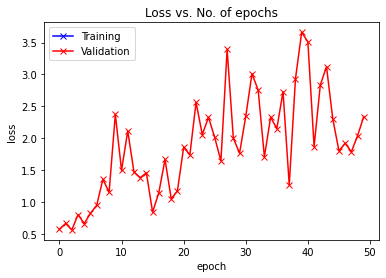

In [ ]:
plot_losses(history)

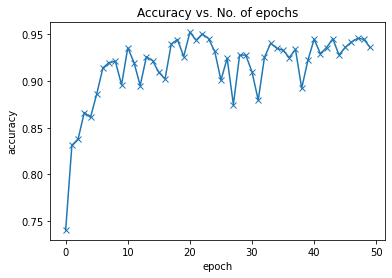

In [ ]:
plot_accuracies(history)

In [ ]:
evaluate(model, test_loader)

In [ ]:
video_level_classification(patient=200,model=model)

4ch success rate 1.0
2ch success rate 1.0


In [ ]:
def load_model_densenet(PATH):
   torch.manual_seed(72)
   my_model = DenseNet121()
   my_model.load_state_dict(torch.load(PATH))
   model = to_device(my_model, device)
   model.eval()
   return model

In [ ]:
def load_model_resnet152(PATH):
   torch.manual_seed(72)
   my_model = ResNet(Bottleneck, [3,8,36,3], num_classes=3, num_channels=3)
   my_model.load_state_dict(torch.load(PATH))
   model = to_device(my_model, device)
   model.eval()
   return model

In [ ]:
images,labels=create_tensor_test_set()
test_ds=MyDataset(images=images,labels=labels)
batch_size=16
test_loader = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=False)

In [ ]:
model=load_model_densenet('drive/MyDrive/training_dataset/densenet121_450_0.001_best.pt')
features=np.ones((32,1024))
labels=np.ones(32)
for batch in test_loader:
    images, label = to_device(batch,device)
    output = model.forward(images)
    current_outputs = output.detach().numpy()
    features = np.vstack((features, current_outputs))
    labels = np.vstack((labels, label.cpu().numpy()))
    print(features.shape)
    print(labels.shape)

In [ ]:
features=0

In [ ]:
def load_model_vgg16(PATH):
   torch.manual_seed(72)
   my_model = ClassificationModel()
   my_model.load_state_dict(torch.load(PATH))
   model = to_device(my_model, device)
   model.eval()
   return model

In [ ]:
device=get_default_device()
PATH='drive/MyDrive/training_dataset/vgg16.pt'
model=load_model(PATH)

In [ ]:
def fetch_image_quality(patient,option):
    if patient<10:
         file_name_4ch = 'drive/MyDrive/training_dataset/training/patient000'+str(patient)+'/Info_4CH.cfg'
         file_name_2ch = 'drive/MyDrive/training_dataset/training/patient000' +str(patient) +'/Info_2CH.cfg'
    elif patient<100 :
         file_name_4ch = 'drive/MyDrive/training_dataset/training/patient00'+str(patient)+'/Info_4CH.cfg'
         file_name_2ch = 'drive/MyDrive/training_dataset/training/patient00' +str(patient) +'/Info_2CH.cfg'
    else :
         file_name_4ch = 'drive/MyDrive/training_dataset/training/patient0'+str(patient)+'/Info_4CH.cfg'
         file_name_2ch = 'drive/MyDrive/training_dataset/training/patient0' +str(patient) +'/Info_2CH.cfg'
    if option=='4CH' :
        with open(file_name_4ch) as f:
           file_content = '[dummy_section]\n' + f.read()
        config_parser =configparser.RawConfigParser()
        config_parser.read_string(file_content)
        image_quality=config_parser['dummy_section']['ImageQuality']
    else :
        with open(file_name_2ch) as f:
           file_content = '[dummy_section]\n' + f.read()
        config_parser =configparser.RawConfigParser()
        config_parser.read_string(file_content)
        image_quality=config_parser['dummy_section']['ImageQuality']
    return image_quality

In [ ]:
image_qual=fetch_image_quality(patient=4,option='2CH')
print(image_qual)

Good


[]


In [ ]:
from sklearn.model_selection import PredefinedSplit
def logistic_classifier(X_train,Y_train,X_val,Y_val,filename):
    split_index = [-1]*len(X_train) + [0]*len(X_val)
    X = np.concatenate((X_train, X_val), axis=0)
    Y = np.concatenate((Y_train, Y_val), axis=0)
    pds = PredefinedSplit(test_fold = split_index)
    clf=LogisticRegression(multi_class='ovr')
    param_grid={
                "C" : np.logspace(-4,4,40),
                "solver":["lbfgs"],
                "max_iter":[100,200,300]
                }
    optimum_model=GridSearchCV(clf,param_grid=param_grid,cv=pds,n_jobs=-1)
    optimum_model.fit(X,Y)
    save_sklearn_model(optimum_model,filename)
    return optimum_model

In [ ]:
def quality_logistic_classifier(X_train,Y_train,filename):
    clf=LogisticRegression()
    param_grid={
                "C" : np.logspace(-4,4,40),
                "solver":["lbfgs"],
                "max_iter":[100,300,400,500]
                }
    optimum_model=GridSearchCV(clf,param_grid=param_grid,cv=10,n_jobs=-1)
    optimum_model.fit(X_train,Y_train)
    save_sklearn_model(optimum_model,filename)
    return optimum_model

In [ ]:
def save_sklearn_model(model,filename):
    pickle.dump(model, open(filename, 'wb'))
def load_sklearn_model(filename):
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

In [ ]:
hog_classification_train()

In [ ]:
def hog_classification_train():
  X_train,Y_train=create_hog_dataset_dataframe(X_train_dataframe)
  X_val,Y_val=create_hog_dataset_dataframe(Val_set_dataframe)
  #X_test,Y_test=create_hog_dataset_test(patients=51)
  filename='drive/MyDrive/training_dataset/logistic_classifier_450_4_hog.sav'
  clf=logistic_classifier(X_train,Y_train,X_val,Y_val,filename)
  sklearn_performance_metrics(clf,X_test,Y_test,binary=True)

In [ ]:
X,Y=create_hog_dataset_test(patients=51)
#sklearn_performance_metrics(clf,X_test,Y_test,binary=True)

NameError: ignored

In [ ]:
def create_hog_dataset_test(patients):
  hog_features_4CH=[]
  hog_features_2CH=[]
  for patient in range(1,patients):
    image_4ch_file=fetch_test_file(patient=patient,option='4CH')
    image_2ch_file=fetch_test_file(patient=patient,option='2CH')
    image_4ch=get_array(image_4ch_file)
    image_2ch=get_array(image_2ch_file)
    for j in range(image_4ch.shape[0]):
        #rgb_image = cv2.cvtColor(image_4ch[j,:,:],cv2.COLOR_GRAY2RGB)
        rgb_image = image_4ch[j,:,:]
        image=preprocessing(rgb_image).numpy()
        hog_features = []
        for channel in range(1):
            hog_feature,hog_image = hog(image[channel,:,:],transform_sqrt=False,
                                        orientations=9,pixels_per_cell=(16,16),cells_per_block=(2, 2),
                                        visualize=True,feature_vector=True)
            hog_features.append(hog_feature)
        hog_features_4CH.append(np.ravel(hog_features))
    for j in range(image_2ch.shape[0]):
        #rgb_image = cv2.cvtColor(image_2ch[j,:,:],cv2.COLOR_GRAY2RGB)
        rgb_image = image_2ch[j,:,:]
        image=preprocessing(rgb_image).numpy()
        hog_features = []
        for channel in range(1):
            hog_feature,hog_image = hog(image[channel,:,:],transform_sqrt=False,
                                        orientations=9,pixels_per_cell=(16,16),cells_per_block=(2, 2),
                                        visualize=True,feature_vector=True)
            hog_features.append(hog_feature)
        hog_features_2CH.append(np.ravel(hog_features))
  X = np.vstack((hog_features_4CH, hog_features_2CH)).astype(np.float64)
  Y = np.hstack((np.zeros(len(hog_features_4CH)), np.ones(len(hog_features_2CH)))).astype(int)
  print(X.shape)
  print(Y.shape)
  return X,Y

In [ ]:
def create_hog_dataset(patients):
  hog_features_4CH=[]
  hog_features_2CH=[]
  for patient in range(1,patients):
    image_4ch_file=fetch_file(patient=patient,option='4CH')
    image_2ch_file=fetch_file(patient=patient,option='2CH')
    image_4ch=get_array(image_4ch_file)
    image_2ch=get_array(image_2ch_file)
    for j in range(image_4ch.shape[0]):
        #rgb_image = cv2.cvtColor(image_4ch[j,:,:],cv2.COLOR_GRAY2RGB)
        rgb_image = image_4ch[j,:,:]
        image=preprocessing(rgb_image).numpy()
        hog_features = []
        for channel in range(1):
            hog_feature,hog_image = hog(image[channel,:,:],transform_sqrt=False,
                                        orientations=9,pixels_per_cell=(16,16),cells_per_block=(2, 2),
                                        visualize=True,feature_vector=True)
            hog_features.append(hog_feature)
        hog_features_4CH.append(np.ravel(hog_features))
    for j in range(image_2ch.shape[0]):
        #rgb_image = cv2.cvtColor(image_2ch[j,:,:],cv2.COLOR_GRAY2RGB)
        rgb_image = image_2ch[j,:,:]
        image=preprocessing(rgb_image).numpy()
        hog_features = []
        for channel in range(1):
            hog_feature,hog_image = hog(image[channel,:,:],transform_sqrt=False,
                                        orientations=9,pixels_per_cell=(16,16),cells_per_block=(2, 2),
                                        visualize=True,feature_vector=True)
            hog_features.append(hog_feature)
        hog_features_2CH.append(np.ravel(hog_features))
  X = np.vstack((hog_features_4CH, hog_features_2CH)).astype(np.float64)
  Y = np.hstack((np.zeros(len(hog_features_4CH)), np.ones(len(hog_features_2CH)))).astype(int)
  print(X.shape)
  print(Y.shape)
  return X,Y

In [ ]:
def create_hog_dataset_dataframe(dataframe):
  hog_features_4CH=[]
  hog_features_2CH=[]
  for patient in dataframe['patient']:
    image_4ch_file=fetch_file(patient=patient,option='4CH')
    image_2ch_file=fetch_file(patient=patient,option='2CH')
    image_4ch=get_array(image_4ch_file)
    image_2ch=get_array(image_2ch_file)
    for j in range(image_4ch.shape[0]):
        #rgb_image = cv2.cvtColor(image_4ch[j,:,:],cv2.COLOR_GRAY2RGB)
        rgb_image = image_4ch[j,:,:]
        image=preprocessing(rgb_image).numpy()
        hog_features = []
        for channel in range(1):
            hog_feature,hog_image = hog(image[channel,:,:],transform_sqrt=False,
                                        orientations=9,pixels_per_cell=(8,8),cells_per_block=(2, 2),
                                        visualize=True,feature_vector=True)
            hog_features.append(hog_feature)
        hog_features_4CH.append(np.ravel(hog_features))
    for j in range(image_2ch.shape[0]):
        #rgb_image = cv2.cvtColor(image_2ch[j,:,:],cv2.COLOR_GRAY2RGB)
        rgb_image = image_2ch[j,:,:]
        image=preprocessing(rgb_image).numpy()
        hog_features = []
        for channel in range(1):
            hog_feature,hog_image = hog(image[channel,:,:],transform_sqrt=False,
                                        orientations=9,pixels_per_cell=(8,8),cells_per_block=(2, 2),
                                        visualize=True,feature_vector=True)
            hog_features.append(hog_feature)
        hog_features_2CH.append(np.ravel(hog_features))
  X = np.vstack((hog_features_4CH, hog_features_2CH)).astype(np.float64)
  Y = np.hstack((np.zeros(len(hog_features_4CH)), np.ones(len(hog_features_2CH)))).astype(int)
  print(X.shape)
  print(Y.shape)
  return X,Y

In [ ]:
for patient in X_train_dataframe['patient']:
  print(patient)

In [ ]:
def create_hog_dataset_quality(dataframe):
  hog_features_4CH=[]
  hog_features_2CH=[]
  X=[]
  Y=[]
  for patient in dataframe['patient']:
    #image_4ch_file=fetch_file(patient=patient,option='4CH')
    image_2ch_file=fetch_file(patient=patient,option='2CH')
    #image_4ch=get_array(image_4ch_file)
    image_2ch=get_array(image_2ch_file)
    #image_4ch_quality=fetch_image_quality(patient=patient,option='4CH')
    image_2ch_quality=fetch_image_quality(patient=patient,option='2CH')
    #label_4ch=get_image_quality_label(image_4ch_quality)
    label_2ch=get_image_quality_label(image_2ch_quality)
    #for j in range(image_4ch.shape[0]):
        #rgb_image = cv2.cvtColor(image_4ch[j,:,:],cv2.COLOR_GRAY2RGB)
        #rgb_image= image_4ch[j,:,:]
        #image=preprocessing(rgb_image).numpy()
        #hog_features = []
        #for channel in range(1):
            #hog_feature,hog_image = hog(image[channel,:,:],transform_sqrt=False,orientations=9,
                                        #pixels_per_cell=(16,16),cells_per_block=(2, 2),
                                        #visualize=True,feature_vector=True)
            #hog_features.append(hog_feature)
        #X.append(np.ravel(hog_features))
        #Y.append(label_4ch)
    for j in range(image_2ch.shape[0]):
        rgb_image = cv2.cvtColor(image_2ch[j,:,:],cv2.COLOR_GRAY2RGB)
        rgb_image= image_2ch[j,:,:]
        image=preprocessing(rgb_image).numpy()
        hog_features = []
        for channel in range(1):
            hog_feature,hog_image = hog(image[channel,:,:],transform_sqrt=False,orientations=9,
                                        pixels_per_cell=(16,16),cells_per_block=(2, 2),
                                        visualize=True,feature_vector=True)
            hog_features.append(hog_feature)
        X.append(np.ravel(hog_features))
        Y.append(label_2ch)
  print(X)
  X = np.array(X)
  Y = np.array(Y)
  print(X.shape)
  print(Y.shape)
  return X,Y

In [ ]:
def create_hog_dataset_quality_test(patients):
  hog_features_4CH=[]
  hog_features_2CH=[]
  X=[]
  Y=[]
  for patient in range(1,patients):
    #image_4ch_file=fetch_test_file(patient=patient,option='4CH')
    image_2ch_file=fetch_test_file(patient=patient,option='2CH')
    #image_4ch=get_array(image_4ch_file)
    image_2ch=get_array(image_2ch_file)
    #image_4ch_quality=fetch_test_image_quality(patient=patient,option='4CH')
    image_2ch_quality=fetch_test_image_quality(patient=patient,option='2CH')
    #label_4ch=get_image_quality_label(image_4ch_quality)
    label_2ch=get_image_quality_label(image_2ch_quality)
    #for j in range(image_4ch.shape[0]):
        #rgb_image = cv2.cvtColor(image_4ch[j,:,:],cv2.COLOR_GRAY2RGB)
        #rgb_image=image_4ch[j,:,:]
        #image=preprocessing(rgb_image).numpy()
        #hog_features = []
        #for channel in range(1):
            #hog_feature,hog_image = hog(image[channel,:,:],transform_sqrt=False,orientations=9,
             #                           pixels_per_cell=(16,16),cells_per_block=(2, 2),
              #                          visualize=True,feature_vector=True)
            #hog_features.append(hog_feature)
        #X.append(np.ravel(hog_features))
        #Y.append(label_4ch)
    for j in range(image_2ch.shape[0]):
        rgb_image = cv2.cvtColor(image_2ch[j,:,:],cv2.COLOR_GRAY2RGB)
        rgb_image=image_2ch[j,:,:]
        image=preprocessing(rgb_image).numpy()
        hog_features = []
        for channel in range(1):
            hog_feature,hog_image = hog(image[channel,:,:],transform_sqrt=False,orientations=9,
                                       pixels_per_cell=(16,16),cells_per_block=(2, 2),
                                       visualize=True,feature_vector=True)
            hog_features.append(hog_feature)
        X.append(np.ravel(hog_features))
        Y.append(label_2ch)
  print(X)
  X = np.array(X)
  Y = np.array(Y)
  print(X.shape)
  print(Y.shape)
  return X,Y

In [ ]:
X_test,Y_test=create_hog_dataset_quality_test(patients=51)
filename='drive/MyDrive/training_dataset/logistic_classifier_2ch_under2_quality_hog.sav'
model=load_sklearn_model(filename)
sklearn_performance_metrics(model,X_test,Y_test,binary=False)

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=fl

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def poor_quality_counter(clf,X_test,Y_test):
  Y_pred=clf.predict(X_test)
  size=Y_pred.shape[0]
  good=Y_pred[Y_pred == 0]
  medium=Y_pred[Y_pred == 1]
  print(f"Size is {size}")
  print(good.shape[0]/size)
  print(medium.shape[0]/size)



In [ ]:
def hog_classification_quality_train():
  X_train,Y_train=create_hog_dataset_quality(X_train_dataframe)
  X_train,Y_train=sampling_strategy(X_train,Y_train)
  X_val,Y_val=create_hog_dataset_quality(Val_set_dataframe)
  print(X_train.shape)
  X_test,Y_test=create_hog_dataset_quality_test(patients=51)
  print(X_train.shape)
  filename='drive/MyDrive/training_dataset/logistic_classifier_2ch_4_under_quality_hog.sav'
  clf=logistic_classifier(X_train,Y_train,X_val,Y_val,filename)
  sklearn_performance_metrics(clf,X_test,Y_test,binary= False)

hog_classification_quality_train()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
def sampling_strategy(X_train,Y_train):
    ros = RandomOverSampler(random_state=42)
    X_res, Y_res = ros.fit_resample(X_train, Y_train)
    return X_res,Y_res

In [ ]:
def sklearn_performance_metrics(model,X_test,Y_test,binary):
  labels=["Good","Medium","Poor"]
  Y_pred=model.predict(X_test)
  if binary == True :
      #print(roc_auc_score(Y_test, model.predict_proba(X_test)[:, 1]))
      labels=['4CH','2CH']
  #print(accuracy_score(Y_test,Y_pred))
  print(balanced_accuracy_score(Y_test,Y_pred))
  print(classification_report(Y_test, Y_pred, target_names=labels))
  print(confusion_matrix(Y_test, Y_pred))



In [ ]:
def patients_quality_images(view_option,quality_option):
    patient_list=[]
    total_patients=451
    total=0
    for patient in range(1,total_patients):
      image_quality=fetch_image_quality(patient,option=view_option)
      if image_quality == quality_option:
         patient_list.append(patient)
      else:
        pass
    return patient_list

In [ ]:
def create_hog_dataset_test_quality_testing(quality_option,view_option):
  X=[]
  Y=[]
  for patient in range(1,51):
    image_quality=fetch_test_image_quality(patient=patient,option=view_option)
    if image_quality != quality_option:
       continue
    label=get_image_quality_label(image_quality)
    image_file=fetch_test_file(patient=patient,option=view_option)
    image=get_array(image_file)
    for j in range(image.shape[0]):
        test_image = image[j,:,:]
        test_image=preprocessing(test_image).numpy()
        for channel in range(1):
            hog_feature,hog_image = hog(test_image[channel,:,:],transform_sqrt=False,
                                        orientations=9,pixels_per_cell=(16,16),cells_per_block=(2, 2),
                                        visualize=True,feature_vector=True)
        X.append(hog_feature)
        Y.append(label)
  X=np.array(X)
  Y=np.array(Y)
  print(X.shape)
  print(Y.shape)
  return X,Y

In [ ]:
def sklearn_test_dataset_performance(X_test,Y_test):
    filename='drive/MyDrive/training_dataset/logistic_classifier_hog.sav'
    model=load_sklearn_model(filename)
    sklearn_performance_metrics(model,X_test,Y_test)

In [ ]:
category_view={
       '4CH':0,
       '2CH':1
   }
filename='drive/MyDrive/training_dataset/logistic_classifier_450_hog.sav'
model=load_sklearn_model(filename)
for view_option in ["4CH","2CH"]:
    for quality in ['Good','Medium','Poor']:
        X_test,Y_test=create_hog_dataset_test_quality_testing(quality_option=quality,view_option=view_option)
        Y_pred=model.predict(X_test)
        view=category_view[view_option]
        correct=Y_pred[Y_pred == view ]
        print(f"{view_option} in the {quality} quality are correctly classified {correct.shape[0]/Y_pred.shape[0]}")

In [ ]:
def sklearn_video_level_classification(patient,model):
  image_4ch_file=fetch_test_file(patient=patient,option='4CH')
  image_2ch_file=fetch_test_file(patient=patient,option='2CH')
  image_4ch=get_array(image_4ch_file)
  image_2ch=get_array(image_2ch_file)
  correct_4ch=0
  correct_2ch=0
  for j in range(image_4ch.shape[0]):
    X=[]
    #rgb_image = cv2.cvtColor(image_4ch[j,:,:],cv2.COLOR_GRAY2RGB)
    rgb_image=image_4ch[j,:,:]
    image=preprocessing(rgb_image).numpy()
    hog_features = []
    for channel in range(1):
        hog_feature = hog(image[channel,:,:],transform_sqrt=False,orientations=9,pixels_per_cell=(16,16),cells_per_block=(2, 2),
                          visualize=False,feature_vector=True)
        hog_features.append(hog_feature)
    X.append(np.ravel(hog_features))
    prediction=model.predict(X)[0]
    if prediction == 0:
      correct_4ch = correct_4ch + 1
  for j in range(image_2ch.shape[0]):
    X=[]
    #rgb_image = cv2.cvtColor(image_2ch[j,:,:],cv2.COLOR_GRAY2RGB)
    rgb_image=image_2ch[j,:,:]
    image=preprocessing(rgb_image).numpy()
    hog_features = []
    for channel in range(1):
        hog_feature = hog(image[channel,:,:],transform_sqrt=False,orientations=9,pixels_per_cell=(16,16),cells_per_block=(2, 2),
                          visualize=False,feature_vector=True)
        hog_features.append(hog_feature)
    X.append(np.ravel(hog_features))
    prediction=model.predict(X)[0]
    if prediction == 1 :
      correct_2ch = correct_2ch + 1
  print(f"4ch success rate {correct_4ch/image_4ch.shape[0]}")
  print(f"2ch success rate {correct_2ch/image_2ch.shape[0]}")
  return correct_4ch/image_4ch.shape[0],correct_2ch/image_2ch.shape[0]


In [ ]:
filename='drive/MyDrive/training_dataset/logistic_classifier_450_hog.sav'
model=load_sklearn_model(filename)
patients_4ch=list()
patients_2ch=list()
for patient in range(1,51):
    video_4ch,video_2ch=sklearn_video_level_classification(patient=patient,model=model)
    patients_4ch.append(video_4ch)
    patients_2ch.append(video_2ch)

In [ ]:
patients_4ch=np.array(patients_4ch)
print(patients_4ch.shape)
print(patients_4ch[patients_4ch==1].shape)
print(patients_4ch[patients_4ch<1])
print(patients_4ch[patients_4ch<1].shape)

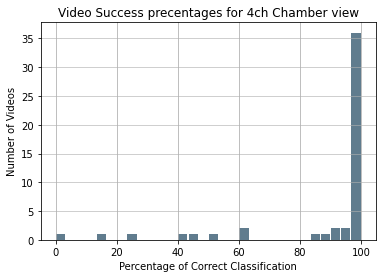

In [ ]:
patient_4ch = pd.Series(patients_4ch*100)

patient_4ch.plot.hist(grid=True, bins=30, rwidth=0.9,
                   color='#607c8e')
plt.title('Video Success precentages for 4ch Chamber view')
plt.xlabel('Percentage of Correct Classification')
plt.ylabel('Number of Videos')
plt.grid(axis='y', alpha=0.75)

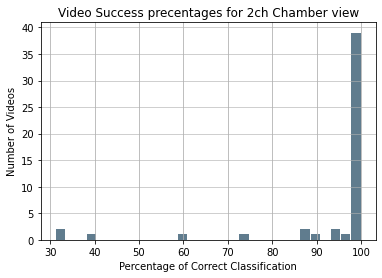

In [ ]:
patient_2ch = pd.Series(np.array(patients_2ch)*100)

patient_2ch.plot.hist(grid=True, bins=30, rwidth=0.9,
                   color='#607c8e')
plt.title('Video Success precentages for 2ch Chamber view')
plt.xlabel('Percentage of Correct Classification')
plt.ylabel('Number of Videos')
plt.grid(axis='y', alpha=0.75)

In [ ]:
def video_level_classification_performance(patients,model):
    video_4ch=[]
    video_2ch=[]
    for patient in range(1,patients):
        correct_4ch,correct_2ch=sklearn_video_level_classification(patient,model)
        video_4ch.append(correct_4ch)
        video_2ch.append(correct_2ch)
    print(video_4ch)
    print(video_2ch)
    print(len(video_4ch))
    video_3dplot(patients,video_4ch,video_2ch)

filename='drive/MyDrive/training_dataset/logistic_classifier_450_hog.sav'
model=load_sklearn_model(filename)
video_level_classification_performance(451,model)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
def video_3dplot(patients,video_4ch,video_2ch):
    x=video_4ch
    y=video_2ch
    z=range(1,patients)
    fig = plt.figure(figsize=(6,6))
    ax = Axes3D(fig)
    fig.add_axes(ax)
    cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
    sc = ax.scatter(x, y, z, s=40, c=x, marker='o', cmap=cmap, alpha=1)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

In [ ]:
def resnet_pretrained():
   model_frozen = torchvision.models.resnet18(pretrained=True)
   for param in model_frozen.parameters():
      param.requires_grad = False
   model_frozen.fc = nn.Linear(model_frozen.fc.in_features, 2)
   return model_frozen

In [ ]:
def vgg16_pretrained():
   model_frozen = torchvision.models.vgg16(pretrained=True)
   for param in model_frozen.parameters():
      param.requires_grad = False
   n_inputs = model_frozen.classifier[6].in_features
   model_frozen.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.7),
    nn.Linear(256, 2), nn.LogSoftmax(dim=1))
   return model_frozen

In [ ]:
def densenet_pretrained():
   model_frozen = torchvision.models.densenet161(pretrained=True)
   for param in model_frozen.parameters():
      param.requires_grad = False
   in_features = model_frozen.classifier.in_features
   model_frozen.classifier = nn.Linear(in_features, 2)
   return model_frozen

In [ ]:
def efficient_net_pretrained():
   model_frozen = torchvision.models.efficientnet_b0(pretrained=True)
   for param in model_frozen.parameters():
      param.requires_grad = False
   model_frozen.classifier[1] = nn.Linear(in_features=1280, out_features=2)
   return model_frozen

In [ ]:
def training_pretrained(pretrained_model,train_loader,val_loader,test_loader):
   model=pretrained_model
   device=get_default_device()
   model = to_device(model, device)
   num_epochs = 10
   opt_func = torch.optim.Adam(model.parameters(),lr=0.001)
   loss_fn = torch.nn.CrossEntropyLoss()
   PATH="drive/MyDrive/training_dataset/resnet_pretrained.pt"
   train_pretrained(model = model, numepochs = num_epochs,
                           train_loader = train_loader,val_loader = val_loader,
                           optimizer = opt_func,lossfun = loss_fn)

model=efficient_net_pretrained()
training_pretrained(pretrained_model=model,train_loader=train_loader,val_loader=val_loader,test_loader=test_loader)

In [ ]:
def train_pretrained(model,numepochs,train_loader,val_loader,optimizer,lossfun):
  trainloss=torch.zeros(numepochs)
  valloss=torch.zeros(numepochs)
  trainacc=torch.zeros(numepochs)
  valacc=torch.zeros(numepochs)
  for epochi in range(numepochs):
    model.train()
    batchloss=[]
    batchacc=[]
    for batch in train_loader:
      X, Y = to_device(batch,device)
      yhat=model(X)
      loss=lossfun(yhat,Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batchloss.append(loss.item())
      batchacc.append(torch.mean((torch.argmax(yhat,axis=1)==Y).float()).item())
    trainloss[epochi]=np.mean(batchloss)
    trainacc[epochi]=100*np.mean(batchacc)
    model.eval()
    batchacc=[]
    batchloss=[]
    for batch in val_loader:
      X, Y = to_device(batch,device)
      with torch.no_grad():
        yhat=model(X)
        loss=lossfun(yhat,Y)
      batchloss.append(loss.item())
      batchacc.append(torch.mean((torch.argmax(yhat,axis=1)==Y).float()).item())
    valloss[epochi]=np.mean(batchloss)
    valacc[epochi]=100*np.mean(batchacc)
    print(f'Finished epoch{epochi + 1 }/{numepochs}.Val accuracy={valacc[epochi]:.2f}%')

In [ ]:
def visualize2DSoftmax(X, y, model, title=None):
    x_min = np.min(X[:,0])-0.5
    x_max = np.max(X[:,0])+0.5
    y_min = np.min(X[:,1])-0.5
    y_max = np.max(X[:,1])+0.5
    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20),np.linspace(y_min, y_max, num=20), indexing='ij')
    xy_v = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1)))
    with torch.no_grad():
        logits = model(torch.tensor(xy_v, dtype=torch.float32))
        y_hat = F.softmax(logits, dim=1).numpy()
    cs = plt.contourf(xv, yv, y_hat[:,0].reshape(20,20),levels=np.linspace(0,1,num=20), cmap=plt.cm.RdYlBu)
    ax = plt.gca()
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=ax)
    if title is not None:
        ax.set_title(title)

visualize2DSoftmax(X, y, model)

In [ ]:
class MyDataset_Autoencoder(torch.utils.data.Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __getitem__(self, index):
        x = self.images[index]

        if self.transform:
            x = Image.fromarray(self.images[index].astype(np.uint8).transpose(1, 2, 0))
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.images)


In [ ]:
def autoencoder_train_loader():
   images,_=create_tensor_set(dataframe)
   train_ds=MyDataset_Autoencoder(images=images)
   batch_size=32
   train_loader = DataLoader(train_ds, batch_size,shuffle=True,num_workers=4, pin_memory=True)
   return train_loader

In [ ]:
def convolutional_autoencoder_train():
  train_loader=autoencoder_train_loader()
  model=Convolutional_Autoencoder()
  model = to_device(model, device)
  num_epochs = 10
  criterian=nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters())
  covnolutional_autoencoder_training(model=model,train_dataloader=train_loader,epochs=num_epochs,optimizer=optimizer,criterian=criterian)
  torch.save(model.state_dict(),'autoencoder.h5')

device=get_default_device()
convolutional_autoencoder_train()

In [ ]:
def covnolutional_autoencoder_training(model,train_dataloader,epochs,optimizer,criterian):
    for epoch in range(epochs):
       model.train()
       iteration = 0
       for data in train_dataloader:
           optimizer.zero_grad()
           data = to_device(data,device)
           output = model.forward(data)
           loss = criterian(output,data)
           loss.backward()
           optimizer.step()
           if iteration%1000 == 0:
              print(f'iteration: {iteration} , loss : {loss.item()}')
       print(f'epoch: {epoch} loss: {loss.item()}')

In [ ]:
def roc_curve_sklearn():
   test_probs_max = []
   for i in range(test_probs.shape[0]):
      test_probs_max.append(test_probs[i,test_y[i]])
   fpr, tpr, thresholds = roc_curve(test_y, np.array(test_probs_max))
   fig,ax = plt.subplots()
   plt.plot(fpr,tpr,label='ROC curve')
   plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
   plt.xlabel('False Positive Rate')
   plt.ylabel('True Positive Rate')
   plt.title('Receiver Operating Characteristic for Email Example')
   plt.legend(loc="lower right")
   plt.show()

In [ ]:
def saliency_map(image,model):
    for param in model.parameters():
        param.requires_grad = False
    model.eval()
    input = preprocessing(img)
    input.unsqueeze_(0)
    input.requires_grad = True
    preds = model(input)
    score, indices = torch.max(preds, 1)
    score.backward()
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    slc = (slc - slc.min())/(slc.max()-slc.min())
     with torch.no_grad():
        input_img = inv_normalize(input[0])
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
nb_frames_4ch_list=[]
nb_frames_2ch_list=[]
ages_list=[]
sex_list=[]
image_quality_4ch_list=[]
image_quality_2ch_list=[]

In [ ]:
for i in range(1,51):
    if i<10:
         file_name_4ch= 'drive/MyDrive/testing_dataset/testing/patient000'+str(i)+'/Info_4CH.cfg'
         file_name_2ch= 'drive/MyDrive/testing_dataset/testing/patient000' +str(i) +'/Info_2CH.cfg'
    else  :
         file_name_4ch= 'drive/MyDrive/testing_dataset/testing/patient00'+str(i)+'/Info_4CH.cfg'
         file_name_2ch= 'drive/MyDrive/testing_dataset/testing/patient00' +str(i) +'/Info_2CH.cfg'
    with open(file_name_4ch) as f:
        file_content = '[dummy_section]\n' + f.read()
    config_parser =configparser.RawConfigParser()
    config_parser.read_string(file_content)
    ages_list.append(int(config_parser['dummy_section']['Age']))
    sex_list.append(config_parser['dummy_section']['Sex'])
    nb_frames_4ch_list.append(int(config_parser['dummy_section']['NbFrame']))
    image_quality_4ch_list.append(config_parser['dummy_section']['ImageQuality'])
    with open(file_name_2ch) as f:
        file_content = '[dummy_section]\n' + f.read()
    config_parser =configparser.RawConfigParser()
    config_parser.read_string(file_content)
    nb_frames_2ch_list.append(int(config_parser['dummy_section']['NbFrame']))
    image_quality_2ch_list.append(config_parser['dummy_section']['ImageQuality'])

In [ ]:
dataframe_test=pd.DataFrame({'Age':ages_list,'Sex':sex_list,'Image_quality_4ch':image_quality_4ch_list,'Nb_frames_4ch':nb_frames_4ch_list,'Image_quality_2ch':image_quality_2ch_list,'Nb_frames_2ch':nb_frames_2ch_list})
dataframe_test['patient']=range(1,51)
print(dataframe_test)
print("Total 4ch examples")
size=len(dataframe_test)
print(dataframe_test['Nb_frames_4ch'].sum())
print("Total 2ch examples")
print(dataframe_test['Nb_frames_2ch'].sum())

In [ ]:
print(dataframe_test['Image_quality_4ch'].value_counts())
print(dataframe_test['Image_quality_2ch'].value_counts())
print(dataframe_test['Sex'].value_counts())
print(dataframe_test["Nb_frames_4ch"].loc[dataframe_test["Image_quality_4ch"] == "Poor" ].sum())
print(dataframe_test["Nb_frames_4ch"].loc[dataframe_test["Image_quality_4ch"] == "Medium" ].sum())
print(dataframe_test["Nb_frames_4ch"].loc[dataframe_test["Image_quality_4ch"] == "Good" ].sum())
print(dataframe_test["Nb_frames_2ch"].loc[dataframe_test["Image_quality_2ch"] == "Poor" ].sum())
print(dataframe_test["Nb_frames_2ch"].loc[dataframe_test["Image_quality_2ch"] == "Medium" ].sum())
print(dataframe_test["Nb_frames_2ch"].loc[dataframe_test["Image_quality_2ch"] == "Good" ].sum())

Good      28
Medium    17
Poor       5
Name: Image_quality_4ch, dtype: int64
Medium    21
Good      19
Poor      10
Name: Image_quality_2ch, dtype: int64
M    38
F    12
Name: Sex, dtype: int64
91
324
573
196
407
377


In [ ]:
def fetch_test_file(patient,option):
      if patient >= 10 :
          image_path_4ch = "drive/MyDrive/testing_dataset/testing/patient00"+str(patient)+"/patient00"+str(patient)+"_4CH_sequence.mhd"
          image_path_2ch = "drive/MyDrive/testing_dataset/testing/patient00"+str(patient)+"/patient00"+str(patient)+"_2CH_sequence.mhd"
      else:
          image_path_4ch = "drive/MyDrive/testing_dataset/testing/patient000"+str(patient)+"/patient000"+str(patient)+"_4CH_sequence.mhd"
          image_path_2ch = "drive/MyDrive/testing_dataset/testing/patient000"+str(patient)+"/patient000"+str(patient)+"_2CH_sequence.mhd"
      if option=='4CH' :
         image_path=image_path_4ch
      else :
         image_path=image_path_2ch
      return image_path

In [ ]:
def fetch_test_image_quality(patient,option):
    if patient<10:
         file_name_4ch = 'drive/MyDrive/testing_dataset/testing/patient000'+str(patient)+'/Info_4CH.cfg'
         file_name_2ch = 'drive/MyDrive/testing_dataset/testing/patient000' +str(patient) +'/Info_2CH.cfg'
    else :
         file_name_4ch = 'drive/MyDrive/testing_dataset/testing/patient00'+str(patient)+'/Info_4CH.cfg'
         file_name_2ch = 'drive/MyDrive/testing_dataset/testing/patient00' +str(patient) +'/Info_2CH.cfg'
    if option == '4CH' :
        with open(file_name_4ch) as f:
           file_content = '[dummy_section]\n' + f.read()
        config_parser =configparser.RawConfigParser()
        config_parser.read_string(file_content)
        image_quality=config_parser['dummy_section']['ImageQuality']
    else :
        with open(file_name_2ch) as f:
           file_content = '[dummy_section]\n' + f.read()
        config_parser =configparser.RawConfigParser()
        config_parser.read_string(file_content)
        image_quality=config_parser['dummy_section']['ImageQuality']
    return image_quality

In [ ]:
def quality_percentage_test(model):
  good_4ch=[]
  medium_4ch=[]
  poor_4ch=[]
  good_2ch=[]
  medium_2ch=[]
  poor_2ch=[]
  frame_4ch_counter=0
  frame_2ch_counter=0
  for patient in range(1,51):
      image_4ch_file=fetch_test_file(patient=patient,option='4CH')
      image_2ch_file=fetch_test_file(patient=patient,option='2CH')
      image_4ch=get_array(image_4ch_file)
      image_2ch=get_array(image_2ch_file)
      true_quality_4ch=fetch_test_image_quality(patient,option='4CH')
      true_quality_2ch=fetch_test_image_quality(patient,option='2CH')
      for j in range(image_4ch.shape[0]):
             rgb_image = cv2.cvtColor(image_4ch[j,:,:],cv2.COLOR_GRAY2RGB)
             tensor_image=preprocessing(rgb_image)
             pred_label=model(tensor_image)
             if pred_label == 1 :
               frame_4ch_counter+=1
               if true_quality_4ch == 'Good':
                   good_4ch.append(0)
               elif true_quality_4ch == 'Medium':
                   medium_4ch.append(0)
               else :
                   poor_4ch.append(0)
      for j in range(image_2ch.shape[0]):
             rgb_image = cv2.cvtColor(image_2ch[j,:,:],cv2.COLOR_GRAY2RGB)
             tensor_image=preprocessing(rgb_image)
             pred_label=model.predict(tensor_image)
             if pred_label == 0 :
               frame_2ch_counter+=1
               if true_quality_2ch == 'Good':
                   good_2ch.append(0)
               elif true_quality_2ch == 'Medium':
                   medium_2ch.append(0)
               else :
                   poor_2ch.append(0)
  print(f"Good 4ch lost are {len(good_4ch)} and precentage is {len(good_4ch)/frame_4ch_counter}")
  print(f"Medium 4ch lost are {len(medium_4ch)} and precentage is {len(medium_4ch)/frame_4ch_counter}")
  print(f"Poor 4ch lost are {len(poor_4ch)} and precentage is {len(poor_4ch)/frame_4ch_counter}")
  print(f"Good 2ch lost are {len(good_2ch)} and precentage is {len(good_2ch)/frame_2ch_counter}")
  print(f"Medium 2ch lost are {len(medium_2ch)} and precentage is {len(medium_2ch)/frame_2ch_counter}")
  print(f"Poor 2ch lost are {len(poor_2ch)} and precentage is {len(poor_2ch)/frame_2ch_counter}")
  return good_4ch,medium_4ch,poor_4ch,good_2ch,medium_2ch,poor_2ch,frame_4ch_counter,frame_2ch_counter




In [ ]:
def quality_percentage_test_hog(model):
  good_4ch=[]
  medium_4ch=[]
  poor_4ch=[]
  good_2ch=[]
  medium_2ch=[]
  poor_2ch=[]
  frame_4ch_counter=0
  frame_2ch_counter=0
  for patient in range(1,51):
      image_4ch_file=fetch_test_file(patient=patient,option='4CH')
      image_2ch_file=fetch_test_file(patient=patient,option='2CH')
      image_4ch=get_array(image_4ch_file)
      image_2ch=get_array(image_2ch_file)
      true_quality_4ch=fetch_test_image_quality(patient,option='4CH')
      true_quality_2ch=fetch_test_image_quality(patient,option='2CH')
      for j in range(image_4ch.shape[0]):
             #rgb_image = cv2.cvtColor(image_4ch[j,:,:],cv2.COLOR_GRAY2RGB)
             rgb_image=image_4ch[j,:,:]
             tensor_image=preprocessing(rgb_image).numpy()
             pred_label=model.predict(tensor_image)
             if pred_label == 1 :
               frame_4ch_counter+=1
               if true_quality_4ch == 'Good':
                   good_4ch.append(0)
               elif true_quality_4ch == 'Medium':
                   medium_4ch.append(0)
               else :
                   poor_4ch.append(0)
      for j in range(image_2ch.shape[0]):
             #rgb_image = cv2.cvtColor(image_4ch[j,:,:],cv2.COLOR_GRAY2RGB)
             rgb_image=image_4ch[j,:,:]
             tensor_image=preprocessing(rgb_image).numpy()
             pred_label=model.predict(tensor_image)
             if pred_label == 0 :
               frame_2ch_counter+=1
               if true_quality_2ch == 'Good':
                   good_2ch.append(0)
               elif true_quality_2ch == 'Medium':
                   medium_2ch.append(0)
               else :
                   poor_2ch.append(0)
  print(f"Good 4ch lost are {len(good_4ch)} and precentage is {len(good_4ch)/frame_4ch_counter}")
  print(f"Medium 4ch lost are {len(medium_4ch)} and precentage is {len(medium_4ch)/frame_4ch_counter}")
  print(f"Poor 4ch lost are {len(poor_4ch)} and precentage is {len(poor_4ch)/frame_4ch_counter}")
  print(f"Good 2ch lost are {len(good_2ch)} and precentage is {len(good_2ch)/frame_2ch_counter}")
  print(f"Medium 2ch lost are {len(medium_2ch)} and precentage is {len(medium_2ch)/frame_2ch_counter}")
  print(f"Poor 2ch lost are {len(poor_2ch)} and precentage is {len(poor_2ch)/frame_2ch_counter}")
  return good_4ch,medium_4ch,poor_4ch,good_2ch,medium_2ch,poor_2ch,frame_4ch_counter,frame_2ch_counter


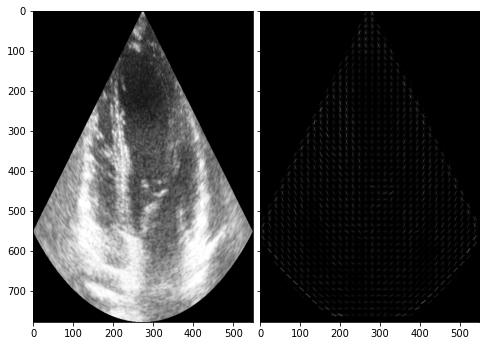

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
image_file_path="drive/MyDrive/training_dataset/training/patient0001/patient0001_4CH_sequence.mhd"
img_4=[]
img = sitk.ReadImage(image_file_path)
img_1=sitk.GetArrayFromImage(img)
img_4.append(img_1[0,:,:])
hog_feature,hog_image = hog(img_1[0,:,:],transform_sqrt=False,
                                        orientations=9,pixels_per_cell=(8,8),cells_per_block=(2, 2),
                                        visualize=True,feature_vector=True)
img_4.append(hog_image)
fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1,2),
                 axes_pad=0.1,
                 )
for ax, im in zip(grid,img_4):
    ax.imshow(im,cmap="gray")

In [ ]:
tmed=pd.read_csv('drive/MyDrive/labeled/labels_per_image.csv')
tmed.drop("diagnosis_label",axis=1,inplace=True)
tmed.drop(tmed[tmed['view_label'] == "PLAX"].index,inplace=True)
tmed.drop(tmed[tmed['view_label'] == "PSAX"].index,inplace=True)
tmed.drop(tmed[tmed['view_label'] == "A4CorA2CorOther"].index,inplace=True)
print(tmed["view_label"].value_counts())
print(tmed)

A4C    4565
A2C    3436
Name: view_label, dtype: int64
           query_key view_label
0       4860s1_0.png        A4C
1       4860s1_1.png        A2C
9       4860s1_9.png        A4C
10     4860s1_10.png        A2C
11     4860s1_11.png        A4C
...              ...        ...
24944  2797s1_13.png        A4C
24958  2797s1_27.png        A2C
24959  2797s1_28.png        A4C
24961    235s1_1.png        A4C
24963    235s1_3.png        A4C

[8001 rows x 2 columns]


In [ ]:
q='3131s2_4.png'
view_label=fetch_tmed_image_quality(tmed,q)
view_label=get_tmed_view_label(view_label)
print(view_label)

1


In [ ]:
def create_tmed_sklearn_set(tmed):
    files = os.listdir('drive/MyDrive/labeled')
    dataset=list()
    dataset_labels=list()
    for file in files:
      query_key=get_query_key(tmed,file)
      if query_key == 0 :
        continue
      image=get_tmed_array(query_key)
      view_label=fetch_tmed_image_quality(tmed,query_key)
      label=get_tmed_view_label(view_label)
      tensor_image=preprocessing(image).numpy()
      hog_feature,hog_image = hog(image,transform_sqrt=False,
                                        orientations=9,pixels_per_cell=(8,8),cells_per_block=(2, 2),
                                        visualize=True,feature_vector=True)
      dataset.append(hog_feature)
      dataset_labels.append(label)
    dataset=np.array(dataset)
    dataset_labels=np.array(dataset_labels)
    return dataset,dataset_labels

In [ ]:
X_test,Y_test=create_tmed_sklearn_set(tmed)
print(X_test.shape)
print(Y_test[Y_test == 0].shape)
print(Y_test[Y_test == 1].shape)
filename='drive/MyDrive/training_dataset/logistic_classifier_450_hog.sav'
model=load_sklearn_model(filename)
sklearn_performance_metrics(model,X_test,Y_test,binary= True)

(4125, 6084)
(2359,)
(1766,)
0.5924848484848485
0.533246807364581
              precision    recall  f1-score   support

         4CH       0.59      0.95      0.73      2359
         2CH       0.62      0.12      0.20      1766

    accuracy                           0.59      4125
   macro avg       0.61      0.53      0.46      4125
weighted avg       0.60      0.59      0.50      4125

[[2230  129]
 [1552  214]]


In [ ]:
def create_tmed_set(tmed):
    files = os.listdir('drive/MyDrive/labeled')
    dataset=list()
    dataset_labels=list()
    for file in files:
      query_key=get_query_key(tmed,file)
      if query_key == 0 :
        continue
      image=get_tmed_array(query_key)
      view_label=fetch_tmed_image_quality(tmed,query_key)
      label=get_tmed_view_label(view_label)
      rgb_image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
      tensor_image=preprocessing(rgb_image)
      dataset.append(tensor_image)
      dataset_labels.append(label)
    return dataset,dataset_labels

In [ ]:
device=get_default_device()
images,labels=create_tmed_set(tmed)
test_ds=MyDataset(images=images,labels=labels)
batch_size=16
test_tmed = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=False)

In [ ]:
filename='drive/MyDrive/training_dataset/resnet152_450_0.001_best.pt'
model=load_model_resnet152(filename)
print_perfomance_metrics(model,test_tmed)

              precision    recall  f1-score   support

         4CH       0.97      0.40      0.57      2359
         2CH       0.55      0.99      0.71      1766

    accuracy                           0.65      4125
   macro avg       0.76      0.69      0.64      4125
weighted avg       0.79      0.65      0.63      4125

[[ 953 1406]
 [  26 1740]]
0.6528484848484849


In [ ]:
def get_query_key(tmed,file):
    if tmed[tmed['query_key'] == file].empty :
      return 0
    else :
      return tmed[tmed['query_key'] == file].values[0][0]

In [ ]:
def get_tmed_view_label(view_label):
  if view_label == 'A4C':
     label=0
  else :
     label=1
  return label

In [ ]:
def get_tmed_array(image_file):
  path_to_file='drive/MyDrive/labeled/'
  im_frame = Image.open(path_to_file + image_file)
  im_frame=brighten_image(im_frame)
  array=np.array(im_frame)
  return array

In [ ]:
def fetch_tmed_image_quality(tmed,file):
    label=tmed[tmed['query_key'] == file].values[0][1]
    return label

In [ ]:
from PIL import ImageEnhance
def brighten_image(image):
    factor = 2
    enhancer = ImageEnhance.Brightness(image)
    im_output = enhancer.enhance(factor)
    enhancer = ImageEnhance.Contrast(image)
    im_output = enhancer.enhance(factor)
    return im_output

In [ ]:
device=get_default_device()
images,labels=create_tensor_set_quality(tmed)
test_tmed_ds=MyDataset(images=images,labels=labels)
batch_size=32
test_tmed_loader = DataLoader(test_tmed_ds, batch_size*2, num_workers=2, pin_memory=False)
#test_dl = DeviceDataLoader(test_tmed_loader, device)

In [ ]:
evaluate(model,test_tmed_loader)

In [ ]:
files = os.listdir('drive/MyDrive/labeled')
print(obj[0])

626s1_13.png


(112, 112)


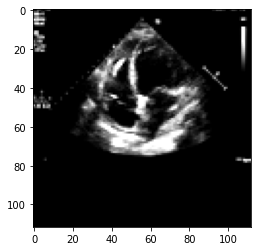

In [ ]:
from PIL import Image
import numpy as np
path_to_file='drive/MyDrive/labeled/'
file='235s1_1.png'
im_frame = get_tmed_array(file)
array=np.array(im_frame)
print(array.shape)
#image_resized = resize(array, (224,224),
                       #anti_aliasing=True)
plt.imshow(array,cmap="gray")


In [ ]:
files = os.listdir('drive/MyDrive/labeled')
for file in files:
    if not tmed[tmed['query_key'] == file].empty :
         print(tmed[tmed['query_key'] == file].values[0][1])

In [ ]:
import random
flag_A4C=0
flag_A2C=0
flag_PLAX=0
flag_PSAX=0
images=[]
label=[]
files = os.listdir('drive/MyDrive/labeled')
random.shuffle(files)
for file in files:
    query_key=get_query_key(tmed,file)
    if query_key == 0 :
        continue
    view_label=fetch_tmed_image_quality(tmed,query_key)
    if view_label == 'A4C' and flag_A4C == 0 :
        image=get_tmed_array(query_key)
        images.append(image)
        label.append(view_label)
        flag_A4C=1
    if view_label == 'A2C' and flag_A2C == 0 :
        image=get_tmed_array(query_key)
        images.append(image)
        label.append(view_label)
        flag_A2C=1
    if view_label == 'PLAX' and flag_PLAX == 0 :
        image=get_tmed_array(query_key)
        images.append(image)
        label.append(view_label)
        flag_PLAX=1
    if view_label == 'PSAX' and flag_PSAX == 0 :
        image=get_tmed_array(query_key)
        images.append(image)
        label.append(view_label)
        flag_PSAX=1
    if flag_A2C+flag_A4C+ flag_PLAX+flag_PSAX == 4:
        break


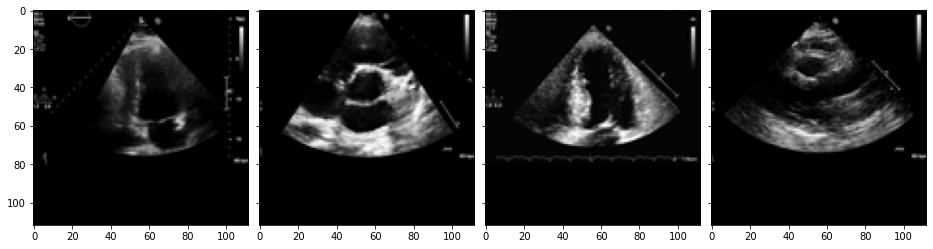

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1,4),
                 axes_pad=0.15,
                 )
for ax, im in zip(grid,images):
    ax.imshow(im,cmap="gray")

In [ ]:
print(label)

['A2C', 'PSAX', 'A4C', 'PLAX']
